## setup

In [1]:
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from models.decoder import Decoder
from models.flow_decoder import FlowDecoder
from models.encoder import Encoder
from utils.load_data import load_dataset, extract_target_properties
from config import DATA_PATH

# === set seed for reproducibility ===
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)  # optional: if using CUDA

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# === specify trial number ===
trial = 4

# === load paths ===
trial_dir = f"checkpoints/trial_{trial}"
decoder_path = os.path.join(trial_dir, f"decoder_ckpt_{trial}.pt")
encoder_path = os.path.join(trial_dir, f"encoder_ckpt_{trial}.pt")
config_path = os.path.join(trial_dir, f"config_{trial}.txt")

# === load data ===
P_all, S_all = load_dataset(DATA_PATH)
P_target = P_all[0].unsqueeze(0).to(device)   # (1, P_dim)
S_true = S_all[0].cpu().numpy()            # (S_dim,)

In [3]:
# === load config from file ===
with open(config_path, "r") as f:
    lines = f.readlines()
config_dict = {line.split(":")[0].strip(): eval(line.split(":")[1].strip()) for line in lines}

# === extract config values ===
S_DIM = config_dict["S_DIM"]
P_DIM = config_dict["P_DIM"]
LATENT_DIM = config_dict["LATENT_DIM"]
DECODER_HIDDEN_DIMS = config_dict["DECODER_HIDDEN_DIMS"]
ENCODER_HIDDEN_DIMS = config_dict["ENCODER_HIDDEN_DIMS"]

# === initialize decoder ===
decoder = Decoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS).to(device)

# NUM_FLOWS = config_dict["NUM_FLOWS"]
# DROPOUT_PROB = config_dict["DROPOUT_PROB"]
# decoder = FlowDecoder(S_DIM, P_DIM, LATENT_DIM, DECODER_HIDDEN_DIMS, NUM_FLOWS, DROPOUT_PROB).to(device)

decoder.load_state_dict(torch.load(decoder_path, map_location=device))
decoder.eval()
print("✅ Loaded decoder from trial", trial)

# === initialize encoder (for latent space visualization) ===
encoder = Encoder(S_DIM, P_DIM, LATENT_DIM, ENCODER_HIDDEN_DIMS).to(device)
encoder.load_state_dict(torch.load(encoder_path, map_location=device))
print("✅ Loaded encoder from trial", trial)

# === print config ===
print("✅ Config for trial", trial)
for k, v in config_dict.items():
    print(f"   - {k}: {v}")

✅ Loaded decoder from trial 4
✅ Loaded encoder from trial 4
✅ Config for trial 4
   - S_DIM: 4
   - P_DIM: 9
   - LATENT_DIM: 4
   - ENCODER_HIDDEN_DIMS: [128, 64, 32]
   - DECODER_HIDDEN_DIMS: [128, 64, 32]
   - BATCH_SIZE: 64
   - LEARNING_RATE: 0.001
   - NUM_EPOCHS: 100
   - BETA: 0.5


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_82485/1311812300.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load(decoder_p

## load in data, sample, extract peaks, run bandwith sanity check

In [4]:
# === run sampling and peak extraction ===
from utils.sampling import get_S_hats, get_S_hat_peaks
S_hats = get_S_hats(decoder, P_target, LATENT_DIM, num_samples=1000, device=device)
S_hat_peaks = get_S_hat_peaks(S_hats, bandwidth=20.0)

# === print number of peaks for different bandwidths ===
print("\n✅ Bandwidth sensitivity:")
for bw in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:
    peaks = get_S_hat_peaks(S_hats, bandwidth=bw)
    print(f"Bandwidth {bw:.1f}: Found {len(peaks)} peak(s)")


✅ Bandwidth sensitivity:
Bandwidth 0.1: Found 945 peak(s)
Bandwidth 0.5: Found 757 peak(s)
Bandwidth 1.0: Found 671 peak(s)
Bandwidth 2.0: Found 531 peak(s)
Bandwidth 5.0: Found 226 peak(s)
Bandwidth 10.0: Found 52 peak(s)
Bandwidth 20.0: Found 8 peak(s)


## visualize encoder latent space

In [5]:
# from utils import visualize_latent as latent

# # === get latent representations ===
# Z_mu = latent.compute_latent_representations(encoder, P_all, S_all, device=device)
# Z_2D = latent.reduce_latent_dim(Z_mu, method='tsne', seed=SEED)

# # === cluster latents ===
# cluster_labels = latent.cluster_latents(Z_mu, n_clusters=3, seed=SEED)
# latent.plot_latents(Z_2D, cluster_labels)

# # === extract cluster region ===
# region_indices = latent.extract_cluster_region(Z_2D, cluster_labels, target_cluster=1, x_bounds=(50, 100), y_bounds=(0, 50))
# latent.print_region_examples(region_indices, S_all, P_all, max_examples=5)

## visualize decoder output space $\hat{S} \sim p(\mathcal{S} \mid \mathcal{P})$ using pca projection

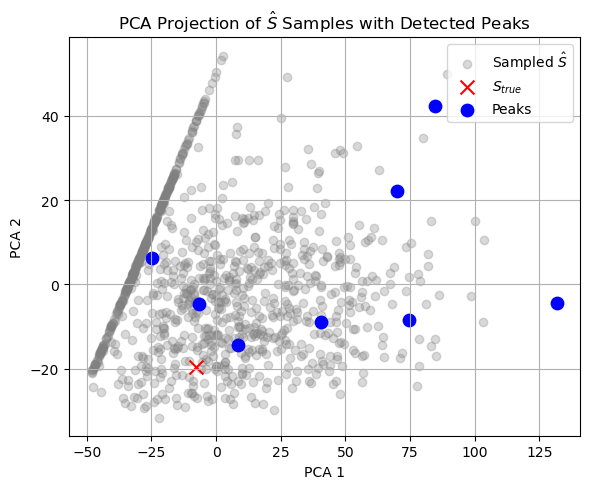

In [6]:
from utils import visualize_output as output

output.plot_S_hat_space(S_hats, S_true, S_hat_peaks)

## load fNN model for evaluation

In [7]:
from utils.mathops import dyad
from functools import partial
from itertools import permutations, product
import tensorflow as tf
from utils.fNN_layers import *

# === load max's fNN model ===
custom_objects = {
    'PermutationEquivariantLayer': PermutationEquivariantLayer,
    'DoubleContractionLayer': DoubleContractionLayer,
    'EnforceIsotropyLayer': EnforceIsotropyLayer,
    'NormalizationLayer': NormalizationLayer
}

fNN = tf.keras.models.load_model('utils/max_fNN.h5', custom_objects=custom_objects)  # adjust path if needed
print("✅ Loaded Max's forward model")

✅ Loaded Max's forward model


Peak   ||P_pred - P_true||    MSE (per peak) 
---------------------------------------------
0      0.3774                 0.0158         
1      0.3383                 0.0127         
2      0.3362                 0.0126         
3      0.3430                 0.0131         
4      0.3605                 0.0144         
5      0.3969                 0.0175         
6      0.3595                 0.0144         
7      0.3639                 0.0147         

✅ Mean MSE across all peaks: 0.0144


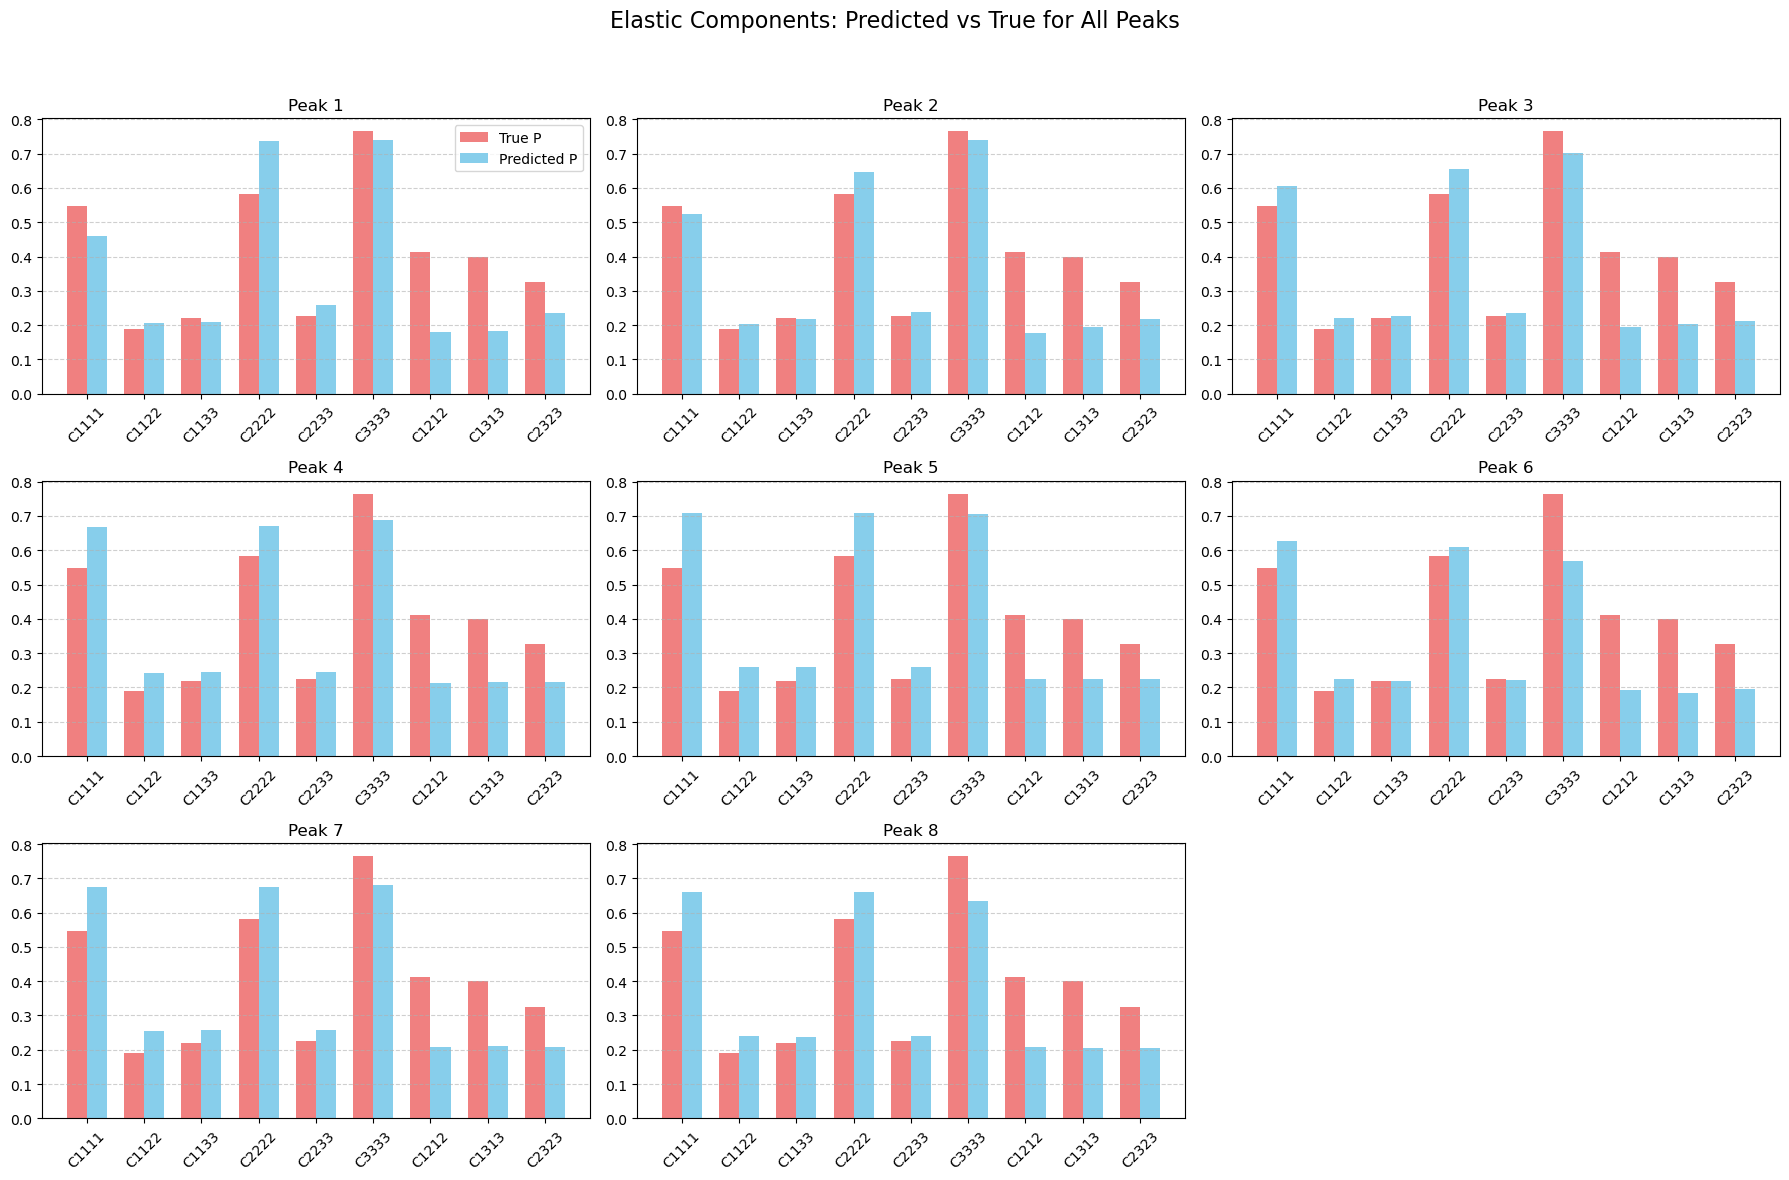

In [8]:
# === evaluate peaks and get prediction metrics ===
P_target_original = P_target  # store original (could be shape (1, 9))
P_target = np.array(P_target).flatten()  # flatten to (9,) for plotting
P_preds, errors, mses = output.evaluate_peaks(S_hat_peaks, P_target, fNN, extract_target_properties)

# === plot predictions vs ground truth ===
output.plot_all_P_preds_vs_true(P_preds, P_target)

# === restore original P_target in case we run an earlier cell===
P_target = P_target_original

In [9]:
closest_idx = np.argmin(np.linalg.norm(S_hats - S_true, axis=1))
closest_dist = np.linalg.norm(S_hats[closest_idx] - S_true)

print(f"Closest sampled S_hat is at index {closest_idx} with distance {closest_dist:.4f}")

Closest sampled S_hat is at index 792 with distance 3.4468
